# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Load Dataset

In [1]:
import pandas as pd
import numpy as np

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\Users\PC\Documents\GitHub\WindPower_Estimation'

dataset_train_1 = pd.read_csv(dataPath+'\Case1\Dataset_Train_1.csv', )
dataset_test_1 = pd.read_csv(dataPath+'\Case1\Dataset_Test_1.csv')

dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [3]:
# Full set
training_set_X = dataset_train_1[['Speed_50m', 'Direction_50m'  ]]
training_set_Y = dataset_train_1[['Park_Power_[KW]'  ]]

test_set_X = dataset_test_1[[ 'Speed_50m', 'Direction_50m' ]]
test_set_Y = dataset_test_1[[ 'Park_Power_[KW]'  ]]

training_set_X_numpy = training_set_X.to_numpy()
training_set_Y_numpy = training_set_Y.to_numpy()
test_set_X_numpy = test_set_X.to_numpy()
test_set_Y_numpy = test_set_Y.to_numpy()




In [4]:
def custom_ts_multi_data_prep(dataset, targetset, start, window, horizon=1, end= None):
    '''
    dataset: the datas that we know and want to predict from, numpy array
    target:  the datas that we want to predict, used for error calculation
    start:   with which indice to start
    window:  how many timestamp we use from the the past, how wide is the window
    horizon: how many future target values are demanded
    '''
    X = []
    y = []
    start = start + window
    if end is None:
        end = dataset.shape[0] - horizon
    
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i, i+horizon )
        y.append(targetset[indicey])
    return np.array(X), np.array(y) 

## Dataloading

In [5]:
hist_window = 96
how_many_PowerkW_values = 1
TRAIN_SPLIT = 30000
x_train, y_train = custom_ts_multi_data_prep(training_set_X_numpy,  training_set_Y_numpy,  start=0,  window=hist_window,  horizon=how_many_PowerkW_values)
x_test,  y_test  = custom_ts_multi_data_prep(test_set_X_numpy,  test_set_Y_numpy,  start=0,  window=hist_window,  horizon=how_many_PowerkW_values)


trainX = Variable(torch.Tensor(np.array(x_train)) )
trainY = Variable(torch.Tensor(np.array(y_train)) )
testX = Variable(torch.Tensor(np.array(x_test)) )
testY = Variable(torch.Tensor(np.array(y_test)) )
 
# #  ----Debug----   
# print('Multiple window of past history\n')
# print( trainX[1]  )
# print('Target horizon\n')
# print(trainY.shape ) 

# print( len(trainX[1]))
# print(trainX[1].reshape(-1) ) 

## Model

In [6]:
class LSTM(nn.Module):

    def __init__(self,  num_features, num_hidden, seq_len, batch_size,  num_layers=1):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = num_features
        self.seq_len = seq_len
        self.hidden_size = num_hidden
#         self.seq_length = seq_length
        
    
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_hidden,
                            num_layers=num_layers, dropout=0.02, batch_first=True ) #dropout=0.1
        
        # Output layer
#         self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) #output_size=1

    
    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')  #.cuda()
        
#         print( x.size(0) )
#         print('================')
        # Initializing cell state for first input with zeros
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')   #.cuda()
        
        # Propagate input through LSTM
#         print('test::::')
#         print(h_0.shape)
#         print(c_0.shape)
#         print(x.shape)
        #print(x.view(seq_len, 1))
        
#         print(f'input size: {x.shape}' )
        x_output, (hn, cn) = self.lstm( x, (h_0, c_0))   #x.view( len(x), self.seq_len, self.hidden_size)
        
#         print( x_output.shape )
#         print( x_output[0:128 , 0:1, :1].shape)
        
        lstm_out = x_output[-1].view(-1, self.hidden_size)  #h_out[-1] should be the results from the last LSTM layer
#         last_time_step = lstm_out.view(self.seq_len, len(x), self.n_hidden)[-1]
#         x_output = self.relu( self.fc1( x_output ) )
        y_pred = self.relu( self.fc2(x_output ) )
    
        return torch.squeeze( y_pred[0:y_pred.size(0) ,-1, :1], 1 )


In [7]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])
    
    
batch_siz = 672
print( training_set_X_numpy.shape)

train_dataset = TimeseriesDataset(training_set_X_numpy, training_set_Y_numpy, seq_len=8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_siz, shuffle = False)

# for i, d in enumerate(train_loader):
#     print(i, d[0].shape, d[1].shape)

(117764, 2)


In [8]:
num_epochs = 20
learning_rate = 0.001
hist_window 
n_features = 2
hidden_size = 20
num_layers = 1

batch_size = 672
num_samples_train = len( training_set_X_numpy )
num_batches_train = (num_samples_train // batch_size ) 
num_samples_test = len( test_set_X_numpy )
num_batches_test = (num_samples_test // batch_size ) 

#-----------------------------------------------------------------------------------
print(f'shape training: {( training_set_X_numpy.shape)}')
remainder_train = len( training_set_X_numpy)%batch_size
print(f'training remainder: {remainder_train}')

for rem in range( remainder_train):
    training_set_X_numpy = np.delete( training_set_X_numpy, 0, axis=0)
    
remainder2_train = len( training_set_X_numpy)%batch_size
print(f'training remainder: {remainder2_train}')
print(f'shape training2: { ( training_set_X_numpy.shape)}')
#------------------------------------------------------------------------------------

print()
print(f'shape test: {( test_set_X_numpy.shape)}')
remainder_test = len( test_set_X_numpy)%batch_size
print(f'test remainder: {remainder_test}')
for rem in range( remainder_test):
    test_set_X_numpy = np.delete( test_set_X_numpy, 0, axis=0)
remainder2_test = len( test_set_X_numpy)%batch_size
print(f'test remainder: {remainder2_test}')
print(f'shape training2: { ( test_set_X_numpy.shape)}')
#------------------------------------------------------------------------------------
print()



lstm = LSTM(num_features=n_features, num_hidden=hidden_size, seq_len=hist_window, num_layers=num_layers, batch_size=batch_size )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_cuda = torch.cuda.is_available()
if use_cuda:
    lstm.to(device)
    print('run on cuda')
    print( next(lstm.parameters()).is_cuda )
print(lstm)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)



train_loss_out = []
test_loss_out = []


# Train the model
for epoch in range(num_epochs):
    
    
    train_dataset = TimeseriesDataset(training_set_X_numpy, training_set_Y_numpy, seq_len=96) 
    train_loader = iter( torch.utils.data.DataLoader(train_dataset, batch_size = batch_siz, shuffle = False))
    
    lstm.train()
    print( f'new epoch, number{epoch}')
    
    batch_train_losses = 0
    # For each sentence in training set
    for index in range( num_batches_train ):
        optimizer.zero_grad()
        x, y = train_loader.next()
        x= x.to('cuda')
        y= y.to('cuda') 
        
#         print(index)
#         print( x.shape )

        outputs = lstm(  x.float() )


        # obtain the loss function
#         print('++++++++')
#         print(outputs.shape)
# #         print(outputs )
# #         print(outputs)
#         print(y.shape)
        train_loss = criterion(outputs, y.float())

        train_loss.backward()

        optimizer.step()
        batch_train_losses += train_loss.cpu().detach().numpy()

#     training_loss = torch.mean(torch.stack (batch_train_losses)  )
    train_loss_out.append( batch_train_losses/training_set_X_numpy.shape[0]  )
        
        
#         optimizer.step()
#         batch_train_losses.append(train_loss)
    
#     training_loss = torch.mean(torch.stack (batch_train_losses)  )
#     train_loss_out.append(training_loss.item())
    
    
    
#         validation_loss = torch.mean(torch.stack (batch_val_losses)  )
#         val_loss_out.append(validation_loss.item())
#     train_loss.append(loss.item())
 
    test_dataset = TimeseriesDataset( test_set_X_numpy, test_set_Y_numpy, seq_len=96) 
    test_loader = iter( torch.utils.data.DataLoader(test_dataset, batch_size = batch_siz, shuffle = False))
    
    lstm.eval()
    with torch.no_grad():
        batch_val_losses = 0
        for index in range( num_batches_test ):
            x_val, y_val = test_loader.next()
            x_val = x_val.to('cuda')
            y_val = y_val.to('cuda') 

            outputs = lstm(  x.float() )

            val_loss = criterion(outputs, y.float())
            batch_val_losses += val_loss.cpu().detach().numpy()
        test_loss_out.append( batch_val_losses/test_set_X_numpy.shape[0]  )   
        
        
#             batch_val_losses.append(val_loss)
#         validation_loss = torch.mean(torch.stack (batch_val_losses)  )
#         val_loss_out.append(validation_loss.item())
    
    print("Epoch: %d, train loss: %1.9f,  test loss: %1.9f" % (epoch, train_loss_out[-1], test_loss_out[-1] ) )

shape training: (117764, 2)
training remainder: 164
training remainder: 0
shape training2: (117600, 2)

shape test: (29441, 2)
test remainder: 545
test remainder: 0
shape training2: (28896, 2)



C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


run on cuda
True
LSTM(
  (lstm): LSTM(2, 20, batch_first=True, dropout=0.02)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)
new epoch, number0


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([672, 1])) that is different to the input size (torch.Size([672])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([577, 1])) that is different to the input size (torch.Size([577])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train loss: 0.000138042,  test loss: 0.000181583
new epoch, number1
Epoch: 1, train loss: 0.000132727,  test loss: 0.000181920
new epoch, number2
Epoch: 2, train loss: 0.000131388,  test loss: 0.000182332
new epoch, number3
Epoch: 3, train loss: 0.000130544,  test loss: 0.000182570
new epoch, number4
Epoch: 4, train loss: 0.000129921,  test loss: 0.000182723
new epoch, number5
Epoch: 5, train loss: 0.000129433,  test loss: 0.000182816
new epoch, number6
Epoch: 6, train loss: 0.000129034,  test loss: 0.000182867
new epoch, number7
Epoch: 7, train loss: 0.000128698,  test loss: 0.000182888
new epoch, number8
Epoch: 8, train loss: 0.000128411,  test loss: 0.000182907
new epoch, number9
Epoch: 9, train loss: 0.000128161,  test loss: 0.000182890
new epoch, number10
Epoch: 10, train loss: 0.000127965,  test loss: 0.000182888
new epoch, number11
Epoch: 11, train loss: 0.000127782,  test loss: 0.000182939
new epoch, number12
Epoch: 12, train loss: 0.000127566,  test loss: 0.000182915

In [9]:
print( test_loss_out   )

[0.0001815830778685354, 0.00018191997272272906, 0.0001823316173007091, 0.00018256983631068752, 0.00018272334931506996, 0.000182815705470386, 0.00018286661777113165, 0.00018288790514426573, 0.00018290701943139234, 0.0001828899784457116, 0.00018288787188274519, 0.00018293900592696098, 0.00018291460305807137, 0.00018289355960275446, 0.00018287496641278267, 0.0001828589897957586, 0.00018284514191604795, 0.00018283276863041378, 0.00018282135992887474, 0.0001828106940679607]


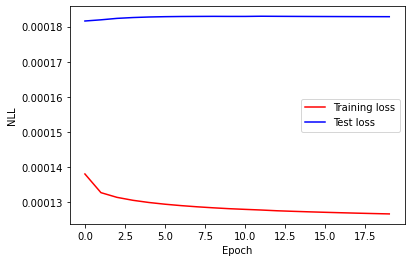

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
epoch = np.arange( len(train_loss_out)   )
plt.figure()
plt.plot(epoch, train_loss_out, 'r', label='Training loss',)
plt.plot(epoch, test_loss_out, 'b', label='Test loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Dataloading

## Model

## Training

## Testing for Park Power values

In [15]:
pred_testX = []

# Predicting first values of the test data with last values of train data
# Each iteration predicts exactly 1 value and adds it to the pred_testX array
# When items for train data cannot be fed into the LSTM, items from pred_testX are used, one by one

window_test_set = np.vstack( (training_set_X[len(training_set_X)-seq_length : len(training_set_X)], [[0],[0]]) )
x, y = sliding_windows(window_test_set, seq_length)
dataX = Variable(torch.Tensor(np.array(x)))

lstm.eval()
test_predict = lstm(dataX)
data_predict = test_predict.data.numpy()
pred_testX.append(data_predict[0])

for i in range(1,seq_length):
  window_test_set = np.vstack((training_set[len(training_set)-seq_length+i:len(training_set)],pred_testX,[[0],[0]]))
  x, y = sliding_windows(window_test_set, seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testX.append(data_predict[0])

# Predicting rest of the 96 values exclusively with predicted data from pred_testX
for i in range(96-seq_length):
  window_test_set = np.vstack((pred_testX[len(pred_testX)-seq_length:len(pred_testX)],[[0],[0]]))
  x, y = sliding_windows(window_test_set, seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testX.append(data_predict[0])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

In [ ]:
# Plotting last train values with test values vs predicted values

lstm.eval()
train_predict = lstm(trainX)

train_predict = train_predict.data.numpy()

dataY_plot = np.vstack((training_set[len(training_set)-224:],test_set[0:97]))
data_predict = np.vstack((train_predict[len(train_predict)-224:],pred_testX))

plt.axvline(x=len(training_set[len(training_set)-224:]), c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()